<a href="https://colab.research.google.com/github/mskmei/FINAL-PROJECT-CV-2022Spring/blob/main/CIFAR100_VisionTransformer_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Vision Transformer</h1>

In this notebook we implement the vision transformer by paddlepaddle on CIFAR100. 在本笔记本中我们在CIFAR100数据集上利用飞桨实现 Vision Transformer.

Author:   
[GitHub](https://github.com/ForeverHaibara)

Original paper: [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929)

In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt 
from tqdm import tqdm 

<h2>Data Preparation</h2>

We prepare the CIFAR100 dataset using torchvision and implement the data augmentation, CutMix.

In [2]:
from torchvision.datasets import CIFAR100
data = CIFAR100(root = './', train = True, download = True)
data_train = {'data': np.array([np.array(data[i][0]) for i in range(50000)]),
        'fine_labels': np.array([data[i][1] for i in range(50000)], dtype='uint8')}
del data 

data = CIFAR100(root = './', train = False, download = True)
data_test = {'data': np.array([np.array(data[i][0]) for i in range(10000)]),
        'fine_labels': np.array([data[i][1] for i in range(10000)], dtype='uint8')}
del data

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./cifar-100-python.tar.gz to ./
Files already downloaded and verified


In [3]:
# all classes of CIFAR-100
data_meta = 'apple aquarium_fish baby bear beaver bed bee beetle bicycle bottle bowl boy bridge bus butterfly camel can castle caterpillar cattle chair chimpanzee clock cloud cockroach couch crab crocodile cup dinosaur dolphin elephant flatfish forest fox girl hamster house kangaroo keyboard lamp lawn_mower leopard lion lizard lobster man maple_tree motorcycle mountain mouse mushroom oak_tree orange orchid otter palm_tree pear pickup_truck pine_tree plain plate poppy porcupine possum rabbit raccoon ray road rocket rose sea seal shark shrew skunk skyscraper snail snake spider squirrel streetcar sunflower sweet_pepper table tank telephone television tiger tractor train trout tulip turtle wardrobe whale willow_tree wolf woman worm'.split()
data_meta = {'fine_label_names': data_meta}
print(len(data_meta['fine_label_names']))

100


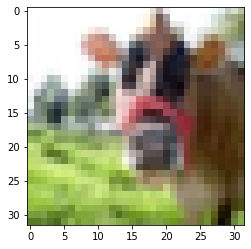

In [4]:
plt.imshow(data_train['data'][0])

In [ ]:
_cuda_ = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(_cuda_)
torch.cuda.set_device(_cuda_)

In [10]:
from PIL import Image 
def augmentate(pics, labels = None, resize = (224, 224), augmentation = False, 
                cut = False, mix = False, rotate = 15):
    '''Simple data augmentator'''
    pics2 = []
    n = pics.shape[0]
    if resize is None:
        resize = pics[0].shape 
    
    if augmentation:
        angles = (np.random.random(n) - .5) * (rotate * 2.)
        flips = np.random.randint(0, 2, n)
        for i in range(n):
            pic = Image.fromarray(pics[i])
            if flips[i]: pic = pic.transpose(Image.FLIP_LEFT_RIGHT)
            pic = pic.resize(resize, Image.ANTIALIAS)
            pic = pic.rotate(angles[i])
            pic = np.array(pic)
            pics2.append(pic)
    
        if cut and not mix:
            # cutout
            cutx = np.random.randint(cut, resize[0], n)
            cuty = np.random.randint(cut, resize[1], n)
            for i in range(n):
                pics2[i][cutx[i]-cut : cutx[i], 
                         cuty[i]-cut : cuty[i], : ] = 0
            labels *= (1. - cut * cut / (pics2[0].size / 3.))

        elif mix and not cut:
            # mixup
            couple = np.arange(n)
            np.random.shuffle(couple)
            propotion = np.random.random(n)

            # warning: do not modify in-place
            pics3 = [propotion[i] * pics2[couple[i]] + (1 - propotion[i]) * pics2[i] 
                        for i in range(n)]

            # pointer
            pics2 = pics3 

            labels = labels + (labels[couple] - labels) * propotion.reshape((n,1))

        elif cut and mix:
            # cutmix
            couple = np.arange(n)
            np.random.shuffle(couple)
            propotion = np.random.random(n)
            rw = (resize[0] * np.sqrt(propotion)).astype('uint8')
            rh = ((resize[1] / resize[0]) * rw).astype('uint8')

            rx = np.random.randint(65535, size = n) % (resize[0] - rw)
            ry = np.random.randint(65535, size = n) % (resize[1] - rh)

            # warning: do not modify in-place
            pics3 = np.array(pics2)
            for i in range(n):
                pics3[i][rx[i] : rx[i]+rw[i], ry[i] : ry[i]+rh[i]] = \
                    pics2[couple[i]][rx[i] : rx[i]+rw[i], ry[i] : ry[i]+rh[i]] 

            # pointer
            pics2 = pics3

            labels = labels + (labels[couple] - labels) * propotion.reshape((n,1))
            
    else: 
        # no augmentation but resizing
        for i in range(pics.shape[0]):
            pic = Image.fromarray(pics[i])
            pic = pic.resize(resize, Image.ANTIALIAS)
            pic = np.array(pic)
            pics2.append(pic)

    return np.array(pics2), labels

def resizer(pics, size):
    '''
    resize pictures to the given size
    '''
    if issubclass(type(pics[0]), np.ndarray):
        pics = [Image.fromarray(pic) for pic in pics]
    
    for i in range(len(pics)):
        pics[i] = pics[i].resize(size, Image.ANTIALIAS)
    
    return pics


def dataloader(data, labels, batch_size = 128, shuffle = True, verbose = True,
                resize = (224,224), augmentation = True, onehot = False,
                cut = False, mix = False, rotate = 15):
    order = np.arange(data.shape[0], dtype = 'int32')
    if shuffle: np.random.shuffle(order)
    labels = np.array(labels)
    __eye = np.eye(np.max(labels) + 1)
    gen = range(data.shape[0] // batch_size)
    if verbose: gen = tqdm(gen)
    for i in gen:
        x = data[order[i * batch_size: i * batch_size + batch_size]]
        l = labels[order[i * batch_size: i * batch_size + batch_size]]

        # extract the onehot encoding
        l = __eye[l]

        # augmentate the data
        x , l = augmentate(x, l, resize = resize, augmentation = augmentation, 
                            cut = cut, mix = mix, rotate = rotate)

        # transpose the dimensions to match (N,C,H,W)
        x = x.transpose((0,3,1,2))
        x = torch.tensor(x, dtype = torch.float32) / 255.

        # retrieve the non-onehot encoding if asked
        if not onehot:
            l = labels[order[i * batch_size: i * batch_size + batch_size]]
        yield x , l



def topk(y, labels, top):
    '''compute the number of hits in the top-k prediction'''
    topy = np.argpartition(y, -top, axis=-1)[:,-top:]
    topy -= labels.reshape((labels.shape[0], 1))
    return topy.size - np.count_nonzero(topy)


def test(net, data, batch_size = 100, resize = (224,224), tops = [1,5],
            verbose = False, label = 'fine', augmentation = False):
    accs = [0] * len(tops)
    tops.sort()
    for x, labels in dataloader(data['data'], data[f'{label}_labels'], resize = resize, 
                                  batch_size = batch_size, shuffle = False, verbose = verbose,
                                  augmentation = augmentation):
        y = net(x.to(_cuda_)).cpu().detach().numpy()
        labels = np.array(labels)
        for i in range(len(tops)):
            t = topk(y, labels, tops[i])
            accs[i] += topk(y, labels, tops[i])
    return np.array(accs) / data['data'].shape[0]

<h2>Network</h2>

We implement the vision transformer. See reference at 
https://github.com/google-research/vision_transformer .

In [54]:
# Reproduce of vision transformer in pytorch
# Author    : https://github.com/ForeverHaibara 
# Reference : https://github.com/google-research/vision_transformer 


import torch   
import numpy as np

# class Encoder
# class MultiheadAttention
# class MLP
# class VisionTransformer


class Encoder(torch.nn.Module):
    def __init__(self, channels, hidden_size, num_heads = 3, linear_dropout = .1, attention_dropout = .1):
        # num_heads == patch_num
        super().__init__()
        
        self.layer_norm1 = torch.nn.LayerNorm(channels)

        # self.attention   = torch.nn.MultiHeadAttention(
        #                                 embed_dim = channels, 
        #                                 num_heads = num_heads, 
        #                                 dropout = attention_dropout)

        self.attention   =  MultiheadAttention(
                                        embed_dim = channels, 
                                        num_heads = num_heads, 
                                        dropout = attention_dropout)

        self.layer_norm2 = torch.nn.LayerNorm(channels)

        self.mlp         = MLPLayer(channels, hidden_size, dropout = linear_dropout)


    def forward(self, x):
        y = self.layer_norm1(x)
        y = self.attention(y)

        x = x + y 

        y = self.layer_norm2(x) 
        y = self.mlp(x) 

        return x + y



class MultiheadAttention(torch.nn.Module):
    def __init__(self, num_heads = 3, embed_dim = 192, dropout = 0.):
        super().__init__() 
        
        assert embed_dim % num_heads == 0, 'Embedding dimension must be divisible by number of heads.'

        self.num_heads = num_heads
        
        # map the input to qkv
        self.qkv = torch.nn.Linear(embed_dim, embed_dim * 3)

        self.dropout = torch.nn.Dropout(dropout)

        self.attention = None
    
    def forward(self, x):
        n, length, embed_dim = x.shape

        # map the input to qkv
        # [n, length, embed_dim] -> [n, length, embed_dim * 3]
        x = self.qkv(x) 

        # partition x into qkv and distribute embeddings to heads
        # [n, length, embed_dim * 3] -> [3, n, heads, length, embed_dim / heads]
        x = x.reshape((n, length, 3, self.num_heads, embed_dim // self.num_heads))
        x = x.permute((2, 0, 3, 1, 4))
            
        q, k, v = x[0], x[1], x[2]

        # first matmul (remember to transpose k)
        attention = torch.matmul(q, k.permute((0,1,3,2)))

        # scale the attention
        attention = attention * (q.shape[-1] ** -0.5)

        # softmax 
        # we store it because it is useful when visualizing
        self.attention = torch.nn.Softmax(dim = -1)(attention)

        # dropout
        attention = self.dropout(self.attention)

        # second matmul, shape = [n, heads, length, embed_dim / heads]
        x = torch.matmul(attention, v)

        # restore shape
        # [n, heads, length, embed_dim / heads] -> [n, length, embed_dim]
        x = x.permute((0, 2, 1, 3)).reshape((n, length, embed_dim))

        return x



class MLPLayer(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size = None, dropout = .1):
        """An MLP layer consists of two linear layers followed with dropout."""
        super().__init__()

        output_size   = output_size or input_size 
        
        self.dense1   = torch.nn.Linear(input_size, hidden_size)
        torch.nn.init.xavier_uniform_(self.dense1.weight)

        self.act1     = torch.nn.LeakyReLU()
        self.dropout1 = torch.nn.Dropout(dropout)


        self.dense2   = torch.nn.Linear(hidden_size, output_size)
        torch.nn.init.xavier_uniform_(self.dense2.weight)
            
        #self.act2     = torch.nn.LeakyReLU()
        self.dropout2 = torch.nn.Dropout(dropout)


    def forward(self, x):
        x = self.dense1(x)
        x = self.act1(x)
        x = self.dropout1(x)

        x = self.dense2(x)
        # x = self.act2(x)
        x = self.dropout2(x)

        return x



class VisionTransformer(torch.nn.Module):
    def __init__(self, input_size = 224, output_size = 100,
                        channels = 192, hidden_size = 768,
                        patch_size = 16, 
                        num_heads = 3, encode_layers = 12, 
                        pos_encoding = True,
                        linear_dropout = 0., attention_dropout = 0., encoding_dropout = 0.):
        super().__init__()

        assert input_size % patch_size == 0, 'Input size must be divisible by patch size.'
        self.input_size = input_size
        self.patch_size = patch_size

        # convolution on each patch is the projection
        self.proj = torch.nn.Conv2d(in_channels = 3, out_channels = channels,
                                     kernel_size = patch_size, stride = patch_size,
                                     padding = 'valid')

        # num of patches
        patch_num = (input_size // patch_size) ** 2 

        # class tokens and (learnable) positional encodings
        self.cls_token = torch.nn.parameter.Parameter(torch.randn((1, 1, channels)))
        self.pos_encoding = torch.nn.parameter.Parameter(
                            torch.randn((1, patch_num + 1, channels))) if pos_encoding is not None else None

        self.dropout = torch.nn.Dropout(encoding_dropout)

        self.encoders = torch.nn.ModuleList(
                                [Encoder(channels  = channels,
                                 hidden_size       = hidden_size,
                                 num_heads         = num_heads,
                                 linear_dropout    = linear_dropout,
                                 attention_dropout = attention_dropout) for _ in range(encode_layers)]
                                            )
        
        self.layer_norm = torch.nn.LayerNorm(channels)

        self.head = torch.nn.Linear(channels, output_size)


    def forward(self, x):
        """Input: torch tensor x with shape [batch_size, 3, height, width]"""
    
        # [batch_size, 3, height, width] -> [batch_size, channels, patch_x, patch_y] by conv
        x = self.proj(x)  

        # [batch_size, channels, patch_x, patch_y] -> [batch_size, channels, patch_num]
        x = torch.flatten(x, 2, 3)

        # [batch_size, channels, patch_num] -> [batch_size, patch_num, channels]
        x = x.permute((0,2,1))
        
        # [batch_size, patch_num, channels] -> [batch_size, patch_num + 1, channels]
        cls = torch.tile(self.cls_token, (x.shape[0], 1, 1))
        x = torch.cat([cls, x], dim = 1)

        # positional encoding
        if self.pos_encoding is not None:
            x = x + self.pos_encoding
        x = self.dropout(x)
        
        # encoders
        for i in range(len(self.encoders)):
            x = self.encoders[i](x)
        
        # layernorm
        x = self.layer_norm(x)

        # reserve the first "patch"
        x = x[:, 0]

        # linear classifier
        x = self.head(x)

        return x


    def visualize(self, x, layer = 0, dtype = 'int'):
        """
        Visualize the attention-guided image of some x with some of the encoders.

        Parameters
        --------
        x    : 4darray, input images with [N,C,H,W] format (C=3) and entries in [0,1]
        layer: int, the index of attention map for visualization (starting from 1, defaults to the last)
        dtype: str, 'int' or 'float' for the dtype of returned images

        Returns
        --------
        imgs     : 4darray, [N,C,H,W] formatted rgba images (C=4)
        attention: 3darray, [N,H,W] formatted, with entries in [0,1]

        Reference:
        https://github.com/jeonsworld/ViT-pytorch/blob/main/visualize_attention_map.ipynb 
        """
        
        if not layer: layer = len(self.encoders)

        # preprocessing, see details in <forward>
        with torch.no_grad():
            _ = self.forward(x)

            device = self.cls_token.device

            # initialization
            attention = torch.eye((self.input_size // self.patch_size)**2 + 1,
                                device = device).unsqueeze(0)
            for i in range(layer):
                # weight size = 65 * 65
                weight = torch.mean(self.encoders[i].attention.attention, dim = 1)

                # bias
                weight += torch.eye(weight.shape[-1], device = device)
                
                # normalize
                weight /= torch.tile(torch.sum(weight, dim = -1).unsqueeze(-1), (1, 1, weight.shape[-1]))

                # accumalate along the layers
                attention = torch.matmul(weight, attention)
            
            # drop the class token in the front
            attention = attention[:, 0, 1:]

            # normalize
            attention = attention  / torch.max(attention, dim = -1)[0].unsqueeze(-1)

            # reshape
            attention = attention.reshape((x.shape[0], 1, 
                            self.input_size // self.patch_size, self.input_size // self.patch_size))

            # tile up to restore the original size of the image by transpose2d
            attention = torch.nn.functional.conv_transpose2d(
                            attention,
                            torch.zeros((1,3, self.patch_size, self.patch_size), 
                                        dtype = torch.float32, device = device) + 1,
                            stride = self.patch_size)
            
            # place the attention map in the alpha channel (rgba imgs)
            imgs = torch.cat((x, attention[:,:1]), dim = 1)
            imgs = imgs.permute((0,2,3,1)).cpu().numpy()

        if 'int' in dtype:
            imgs = (imgs * 255.).clip(0, 255).astype('uint8')
        return imgs, attention

In [12]:
resize = (32, 32)
patch_size = 4#resize[0] // 7
net = VisionTransformer(input_size = resize[0], channels = 192, hidden_size = 768, encode_layers = 12,
                num_heads = 3, patch_size = patch_size, linear_dropout = 0., attention_dropout = 0.)
optim = torch.optim.Adam(net.parameters(), lr = 3e-4)
scheduler = torch.optim.lr_scheduler.LinearLR(optim,
        start_factor = 3e-5, end_factor = 1, total_iters = 780, verbose=False)
net = net.to(_cuda_)
losses = []
accs = []

In [27]:
from torchsummary import summary
summary(net, input_size = (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 192, 8, 8]           9,408
           Dropout-2              [-1, 65, 192]               0
         LayerNorm-3              [-1, 65, 192]             384
            Linear-4              [-1, 65, 576]         111,168
           Dropout-5            [-1, 3, 65, 65]               0
MultiheadAttention-6              [-1, 65, 192]               0
         LayerNorm-7              [-1, 65, 192]             384
            Linear-8              [-1, 65, 768]         148,224
         LeakyReLU-9              [-1, 65, 768]               0
          Dropout-10              [-1, 65, 768]               0
           Linear-11              [-1, 65, 192]         147,648
          Dropout-12              [-1, 65, 192]               0
         MLPLayer-13              [-1, 65, 192]               0
          Encoder-14              [-1, 

In [13]:
epochs = 60
batch_size = 128
from time import sleep
for epoch in range(len(accs) + 1, len(accs) + 1 + epochs):
    for x, labels in dataloader(data_train['data'], data_train['fine_labels'], verbose = True,
                augmentation=True, onehot = True, cut = resize[0]//4, mix = 1,
                rotate = 6, resize = resize, batch_size = batch_size):
        y = net(x.to(_cuda_))
        labels = torch.tensor(labels, dtype = torch.float32, device = _cuda_)
        
        y = torch.nn.Softmax(dim=-1)(y)
        loss = torch.nn.functional.binary_cross_entropy(y, labels)

        losses.append(loss.item())
        optim.zero_grad()
        loss.backward()
        optim.step()
        if scheduler is not None:
            scheduler.step()
    accs.append(test(net, data_test, resize = resize))
    print('Epochs =', epoch, ' Acc =',accs[-1])
    sleep(.1)
    if accs[-1][0] >= max([i[0] for i in accs]):
      torch.save(net.state_dict(), 'model.pth')


100%|██████████| 390/390 [00:49<00:00,  7.85it/s]


Epochs = 1  Acc = [0.034  0.1499]


100%|██████████| 390/390 [00:50<00:00,  7.66it/s]


Epochs = 2  Acc = [0.0476 0.187 ]


100%|██████████| 390/390 [00:51<00:00,  7.57it/s]


Epochs = 3  Acc = [0.0858 0.2763]


100%|██████████| 390/390 [00:50<00:00,  7.67it/s]


Epochs = 4  Acc = [0.0972 0.3021]


100%|██████████| 390/390 [00:50<00:00,  7.66it/s]


Epochs = 5  Acc = [0.1292 0.3573]


100%|██████████| 390/390 [00:50<00:00,  7.65it/s]


Epochs = 6  Acc = [0.1509 0.4014]


100%|██████████| 390/390 [00:50<00:00,  7.66it/s]


Epochs = 7  Acc = [0.1804 0.4483]


100%|██████████| 390/390 [00:50<00:00,  7.67it/s]


Epochs = 8  Acc = [0.1848 0.4621]


100%|██████████| 390/390 [00:50<00:00,  7.67it/s]


Epochs = 9  Acc = [0.1957 0.4819]


100%|██████████| 390/390 [00:50<00:00,  7.68it/s]


Epochs = 10  Acc = [0.2191 0.496 ]


100%|██████████| 390/390 [00:50<00:00,  7.68it/s]


Epochs = 11  Acc = [0.236  0.5194]


100%|██████████| 390/390 [00:50<00:00,  7.67it/s]


Epochs = 12  Acc = [0.2387 0.529 ]


100%|██████████| 390/390 [00:50<00:00,  7.66it/s]


Epochs = 13  Acc = [0.2635 0.5537]


100%|██████████| 390/390 [00:50<00:00,  7.65it/s]


Epochs = 14  Acc = [0.2755 0.5571]


100%|██████████| 390/390 [00:50<00:00,  7.66it/s]


Epochs = 15  Acc = [0.2823 0.5756]


100%|██████████| 390/390 [00:50<00:00,  7.66it/s]


Epochs = 16  Acc = [0.2833 0.5763]


100%|██████████| 390/390 [00:50<00:00,  7.67it/s]


Epochs = 17  Acc = [0.2962 0.5838]


100%|██████████| 390/390 [00:50<00:00,  7.66it/s]


Epochs = 18  Acc = [0.3078 0.6076]


100%|██████████| 390/390 [00:50<00:00,  7.66it/s]


Epochs = 19  Acc = [0.3186 0.6143]


100%|██████████| 390/390 [00:50<00:00,  7.66it/s]


Epochs = 20  Acc = [0.3157 0.6115]


100%|██████████| 390/390 [00:50<00:00,  7.68it/s]


Epochs = 21  Acc = [0.3339 0.6273]


100%|██████████| 390/390 [00:50<00:00,  7.69it/s]


Epochs = 22  Acc = [0.3399 0.635 ]


100%|██████████| 390/390 [00:50<00:00,  7.69it/s]


Epochs = 23  Acc = [0.3465 0.6434]


100%|██████████| 390/390 [00:50<00:00,  7.68it/s]


Epochs = 24  Acc = [0.3459 0.6353]


100%|██████████| 390/390 [00:50<00:00,  7.66it/s]


Epochs = 25  Acc = [0.3491 0.6455]


100%|██████████| 390/390 [00:50<00:00,  7.67it/s]


Epochs = 26  Acc = [0.3596 0.649 ]


100%|██████████| 390/390 [00:50<00:00,  7.66it/s]


Epochs = 27  Acc = [0.3681 0.6628]


100%|██████████| 390/390 [00:50<00:00,  7.67it/s]


Epochs = 28  Acc = [0.3715 0.6582]


100%|██████████| 390/390 [00:50<00:00,  7.67it/s]


Epochs = 29  Acc = [0.3668 0.6619]


100%|██████████| 390/390 [00:50<00:00,  7.67it/s]


Epochs = 30  Acc = [0.3763 0.6721]


100%|██████████| 390/390 [00:50<00:00,  7.66it/s]


Epochs = 31  Acc = [0.3831 0.6706]


100%|██████████| 390/390 [00:50<00:00,  7.66it/s]


Epochs = 32  Acc = [0.3865 0.6769]


100%|██████████| 390/390 [00:50<00:00,  7.67it/s]


Epochs = 33  Acc = [0.3866 0.6783]


100%|██████████| 390/390 [00:50<00:00,  7.67it/s]


Epochs = 34  Acc = [0.3799 0.671 ]


100%|██████████| 390/390 [00:50<00:00,  7.67it/s]


Epochs = 35  Acc = [0.3876 0.6842]


100%|██████████| 390/390 [00:50<00:00,  7.67it/s]


Epochs = 36  Acc = [0.3951 0.6843]


100%|██████████| 390/390 [00:50<00:00,  7.67it/s]


Epochs = 37  Acc = [0.3936 0.6809]


100%|██████████| 390/390 [00:50<00:00,  7.67it/s]


Epochs = 38  Acc = [0.4044 0.6857]


100%|██████████| 390/390 [00:50<00:00,  7.68it/s]


Epochs = 39  Acc = [0.3964 0.689 ]


100%|██████████| 390/390 [00:50<00:00,  7.67it/s]


Epochs = 40  Acc = [0.4089 0.6906]


100%|██████████| 390/390 [00:50<00:00,  7.69it/s]


Epochs = 41  Acc = [0.4107 0.6965]


100%|██████████| 390/390 [00:50<00:00,  7.69it/s]


Epochs = 42  Acc = [0.4035 0.686 ]


100%|██████████| 390/390 [00:50<00:00,  7.69it/s]


Epochs = 43  Acc = [0.4086 0.6918]


100%|██████████| 390/390 [00:50<00:00,  7.69it/s]


Epochs = 44  Acc = [0.409  0.6847]


100%|██████████| 390/390 [00:50<00:00,  7.69it/s]


Epochs = 45  Acc = [0.4072 0.6949]


100%|██████████| 390/390 [00:50<00:00,  7.67it/s]


Epochs = 46  Acc = [0.4069 0.689 ]


100%|██████████| 390/390 [00:50<00:00,  7.66it/s]


Epochs = 47  Acc = [0.4118 0.6938]


100%|██████████| 390/390 [00:50<00:00,  7.67it/s]


Epochs = 48  Acc = [0.4106 0.6826]


100%|██████████| 390/390 [00:50<00:00,  7.67it/s]


Epochs = 49  Acc = [0.4141 0.6917]


100%|██████████| 390/390 [00:50<00:00,  7.66it/s]


Epochs = 50  Acc = [0.4156 0.6915]


100%|██████████| 390/390 [00:50<00:00,  7.67it/s]


Epochs = 51  Acc = [0.4115 0.6874]


100%|██████████| 390/390 [00:50<00:00,  7.66it/s]


Epochs = 52  Acc = [0.4102 0.684 ]


100%|██████████| 390/390 [00:50<00:00,  7.66it/s]


Epochs = 53  Acc = [0.4103 0.6832]


100%|██████████| 390/390 [00:50<00:00,  7.66it/s]


Epochs = 54  Acc = [0.4106 0.6912]


100%|██████████| 390/390 [00:50<00:00,  7.66it/s]


Epochs = 55  Acc = [0.4145 0.688 ]


100%|██████████| 390/390 [00:50<00:00,  7.66it/s]


Epochs = 56  Acc = [0.4106 0.6904]


100%|██████████| 390/390 [00:50<00:00,  7.66it/s]


Epochs = 57  Acc = [0.416 0.687]


100%|██████████| 390/390 [00:50<00:00,  7.66it/s]


Epochs = 58  Acc = [0.4122 0.6833]


100%|██████████| 390/390 [00:50<00:00,  7.67it/s]


Epochs = 59  Acc = [0.4157 0.6853]


100%|██████████| 390/390 [00:50<00:00,  7.66it/s]


Epochs = 60  Acc = [0.4123 0.6873]


In [16]:
# measure the training acc
print('\nTop1 and Top5 Train Acc =', test(net, data_train, batch_size = 100, resize = resize, verbose=True))

100%|██████████| 500/500 [00:20<00:00, 24.50it/s]


Top1 and Top5 Train Acc = [0.87488 0.97852]


Top1 and Top5 Test Acc = 0.416 0.6965


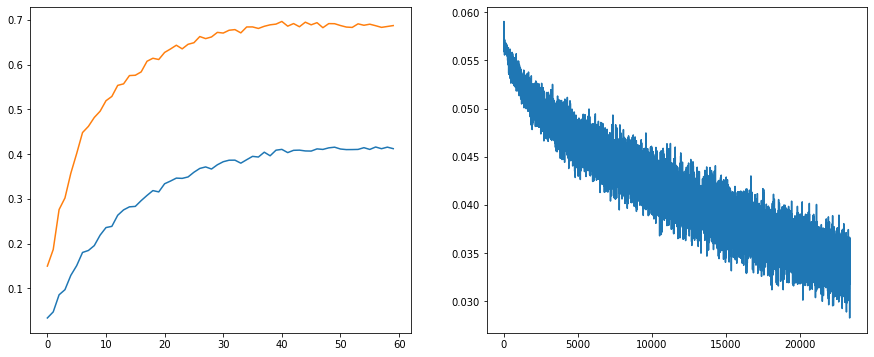

In [15]:
# display the testing acc
print('Top1 and Top5 Test Acc =', max([i[0] for i in accs]), max([i[1] for i in accs]))
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(accs)
plt.subplot(1,2,2)
plt.plot(losses)

In [17]:
# write the log
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('./')
for i in range(len(losses)):
  writer.add_scalar(tag="train/loss", global_step = i, scalar_value = losses[i]) 
for i in range(len(accs)): 
  writer.add_scalar(tag="valid/top1 acc", global_step = i, scalar_value = accs[i][0])  
  writer.add_scalar(tag="valid/top5 acc", global_step = i, scalar_value = accs[i][1]) 

<h2>Visualize</h2>

Visualize the attention map.

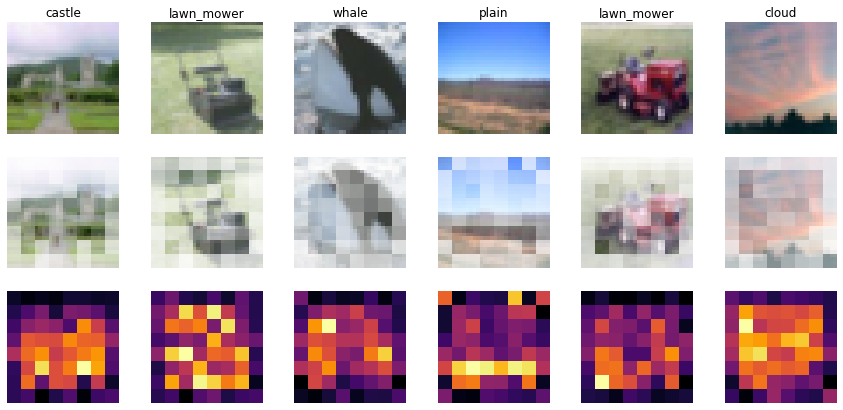

In [63]:
batch_size = 100
np.random.seed(4)
for x, labels in dataloader(data_train['data'], data_train['fine_labels'], verbose = 0,
            augmentation=0, onehot = True, cut = resize[0]//4, mix = 1, 
                rotate = 6, resize = resize, batch_size = batch_size):
    imgs, attention = net.visualize(x.to(_cuda_), layer = 12)
    attention = attention.cpu().numpy()
    break 

plt.figure(figsize = (15, 7))
show = 6
for i in range(show):
    plt.subplot(3, show, 1 + i)
    plt.axis('off')
    plt.imshow(x[i].permute((1,2,0)))
    plt.title(data_meta['fine_label_names'][np.argmax(labels[i])])
    plt.subplot(3, show, show + 1 + i)
    plt.axis('off')
    plt.imshow(imgs[i])
    plt.subplot(3, show, 2*show + 1 + i)
    plt.axis('off')
    plt.imshow(attention[i][0], cmap='inferno')
plt.show()

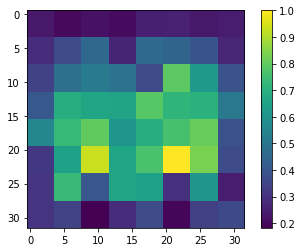

In [64]:
plt.imshow(attention[0][0])
plt.colorbar()